0.01
  5.964292 seconds (29.72 M allocations: 2.291 GiB, 5.97% gc time, 22.03% compilation time)


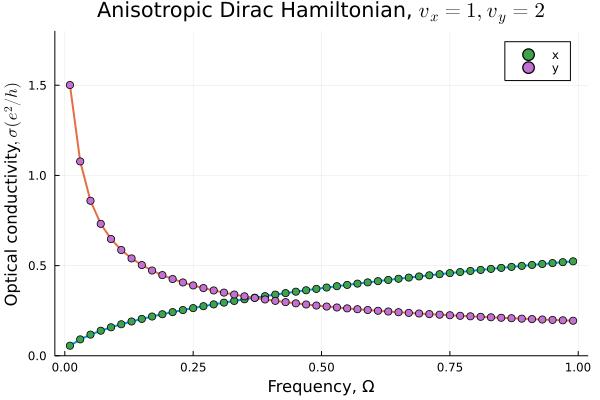

In [36]:
# using Printf
using Plots
using Roots
using DelimitedFiles
using LinearAlgebra
using HCubature
using LaTeXStrings
using TOML

const ħ=1


function δ(x,η)
    return (1/π)* η / (η^2 + x^2)
end

function fermi(x,β)
    return 1 / (1 + e^(β*x)) 
end

function Hamilt(K,param)
    kx = K[1] ; ky = K[2]
        H11 = param.V
        H22 = -H11
        H12 = param.Δ + ħ^2/(2*param.mx) * kx^2  +  ħ^2/(2*param.my) * ky^2  +  ħ*param.vx*kx - im*ħ*param.vy*ky
        H21 = conj(H12)
        H = [     H11         H12       ; 
                  H21         H22       ]
    return H
end

function Velocity(K,param)
    kx = K[1] ; ky = K[2]
    V11 = 0
    V22 = V11
    V12x =  ħ/param.mx * kx  +  param.vx
    Vx = [    V11      V12x  ;
           conj(V12x)   V22  ]
    V12y =  ħ/param.my * ky  - im*param.vy
    Vy = [    V11      V12y  ;
           conj(V12y)   V22  ]
    return Vx,Vy
end


function Conductivity(Ω,param)  
    function kernel(K)
          E = eigvals(Hamilt(K,param))
          U = eigvecs(Hamilt(K,param))
          Vxmat,Vymat = Velocity(K,param)
          Vxmat_rot = U'* Vxmat * U
          Vymat_rot = U'* Vymat * U
          Vx2 = real(Vxmat_rot[1,2]*Vxmat_rot[2,1])
          Vy2 = real(Vymat_rot[1,2]*Vymat_rot[2,1])
          kern = 1 / (E[2]-E[1]) / (E[2]-E[1] - Ω - im*η)
          return [kern * Vx2 , kern * Vy2]
    end
Kmin = [0;0]
(cond,err) = hcubature(K -> kernel(K), Kmin, Kmax; norm=norm, rtol=rtl, atol=atl)
return imag.(cond) * 4*2pi /  (4π^2)
end


function Find_kmax(Ωmax,param)
    epsilon = 1e-6
    factor = 1 -η * log(epsilon) #  cuts off Fermi tails smaller than epsilon
    function fx(k)
        f = eigmax(Hamilt([k,0],param)) - factor*Ωmax/2
        return f
    end
    function fy(k)
        f = eigmax(Hamilt([0,k],param)) - factor*Ωmax/2
    return f
    end
    kxmax = find_zero(fx, param.V, Order0())
    kymax = find_zero(fy, param.V, Order0())
    return [kxmax,kymax]
end
    

mutable struct MatConst
    mx::Float64
    my::Float64
    vx::Float64
    vy::Float64    
    Δ::Float64
    V::Float64
end

function main()
input = TOML.parsefile("conf.toml")
global η = input["eta"]
global (rtl, atl) = [input["rtol"], input["atol"]]
param = MatConst(input["mx"], input["my"], input["vx"], input["vy"], input["halfgap"], input["V"])
(dΩ, Ωmax, Ωmin) = [input["dW"], input["Wmax"], input["Wmin"]]
(param.mx > 1e4) && (param.mx = Inf)
(param.my > 1e4) && (param.my = Inf)
global Kmax = Find_kmax(Ωmax,param)
    println(η)
#
    cond = [Conductivity(Ω,param) for Ω = Ωmin : dΩ : Ωmax]
    (condx,condy) = (hcat(cond...)[1,:] , hcat(cond...)[2,:] )  # reshaping
    #
    Ω = Ωmin : dΩ : Ωmax
    open("conductivity.dat", "w") do io
        writedlm(io, [Ω condx condy])
    end
    #
    ylimmax = maximum([condx;condy]) *1.2
    Ω = Ωmin : dΩ : Ωmax
    plot(Ω, condx,lw=2,xlabel="Frequency, Ω",ylabel="Optical conductivity"*L", σ (e^2/h)", label="", ylim=(0,ylimmax))
    plot!(Ω, condy,lw=2, label="")
    plot!(Ω, condx, seriestype=:scatter, lw=2, label="x")
    plot!(Ω, condy, seriestype=:scatter, lw=2, label="y")
    #title!("Δ=$(param.Δ), mx=$(param.mx), my=$(param.my), vx=$(param.vx), vy=$(param.vy), V=$(param.V)")
 title!("Anisotropic Dirac Hamiltonian, "*L"v_x=1, v_y=2")
end


@time begin

    main()

end

In [35]:
savefig("semidirac.png")